# Time-Series Forecasting – Stock Prices

## Fetch Dataset from Yahoo Finance 

In [207]:
import datetime
import yfinance as yf
start_date = datetime.datetime(2020, 10, 1)
end_date = datetime.datetime(2025, 9, 1)
meta = yf.Ticker("AAPL")
data = meta.history(start=start_date, end=end_date)

## Export data to CSV file

In [208]:
data.to_csv("../data/AAPL_stock_data.csv")
print("Data exported to ../data/AAPL_stock_data.csv")
print(f"File saved with {len(data)} rows and {len(data.columns)} columns")

Data exported to ../data/AAPL_stock_data.csv
File saved with 1234 rows and 7 columns


## Importing libreries 

In [209]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


## Data Preprocessing

In [210]:
df = pd.read_csv("../data/AAPL_stock_data.csv")
df.head()

Date        Open        High         Low       Close  \
0  2020-10-01 00:00:00-04:00  114.430515  114.508334  112.669898  113.603706   
1  2020-10-02 00:00:00-04:00  109.810111  112.222454  109.158392  109.936562   
2  2020-10-05 00:00:00-04:00  110.802282  113.467526  110.452103  113.321617   
3  2020-10-06 00:00:00-04:00  112.543451  112.951998  109.187577  110.072754   
4  2020-10-07 00:00:00-04:00  111.492912  112.397540  111.016275  111.940361   

      Volume  Dividends  Stock Splits  
0  116120400        0.0           0.0  
1  144712000        0.0           0.0  
2  106243800        0.0           0.0  
3  161498200        0.0           0.0  
4   96849000        0.0           0.0

In [211]:
df = df.drop(['Dividends', 'Stock Splits'], axis=1)
# Convert to datetime and then extract just the date part
df['Date'] = pd.to_datetime(df['Date'], utc=True).dt.strftime('%Y-%m-%d')
df.head()

Date        Open        High         Low       Close     Volume
0  2020-10-01  114.430515  114.508334  112.669898  113.603706  116120400
1  2020-10-02  109.810111  112.222454  109.158392  109.936562  144712000
2  2020-10-05  110.802282  113.467526  110.452103  113.321617  106243800
3  2020-10-06  112.543451  112.951998  109.187577  110.072754  161498200
4  2020-10-07  111.492912  112.397540  111.016275  111.940361   96849000

In [212]:
df.set_index('Date',inplace=True)

In [213]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1234 entries, 2020-10-01 to 2025-08-29
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    1234 non-null   float64
 1   High    1234 non-null   float64
 2   Low     1234 non-null   float64
 3   Close   1234 non-null   float64
 4   Volume  1234 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 57.8+ KB


There is no missing value.

## Visualize the trends 

In [214]:
df['Close'].plot(title="Meta Stock Price (Last 5 Years)")
plt.xlabel("Date")
plt.ylabel("Close Price (USD)")
plt.show()

Plot above shows that the price of the stock increases over time. 

## Model Implementation

### Traditional statistical model ARIMA

To apply the ARIMA model we have to check the data is stationary or not.

In [215]:
from statsmodels.tsa.stattools import adfuller

values = df['Close'].values
result = adfuller(values)

print('Augmneted Dickey_fuller Statistic: %f' % result[0])
print('p-value: %f' % result[1])

print('critical values at different levels:')
for k, v in result[4].items():
    print('\t%s: %.3f' % (k, v))

Augmneted Dickey_fuller Statistic: -1.428009
p-value: 0.568777
critical values at different levels:
	1%: -3.436
	5%: -2.864
	10%: -2.568




Result: The data is NOT stationary

p-value (0.568777) > 0.05: We fail to reject the null hypothesis of non-stationarity
ADF statistic (-1.428) is greater than critical values, indicating non-stationarity
This is expected for stock prices, which typically show trends and don't revert to a constant mean


In [216]:
df['Close_diff'] = df['Close'] - df['Close'].shift(1)
df['Close'].shift(1)

Date
2020-10-01           NaN
2020-10-02    113.603706
2020-10-05    109.936562
2020-10-06    113.321617
2020-10-07    110.072754
                 ...    
2025-08-25    227.759995
2025-08-26    227.160004
2025-08-27    229.309998
2025-08-28    230.490005
2025-08-29    232.559998
Name: Close, Length: 1234, dtype: float64

In [217]:
values = df['Close_diff'].dropna().values
result1 = adfuller(values)

print('Augmented Dickey-Fuller Statistic: %f' % result1[0])
print('p-value: %f' % result1[1])

print('critical values at different levels:')
for k, v in result1[4].items():
    print('\t%s: %.3f' % (k, v))

Augmented Dickey-Fuller Statistic: -20.701979
p-value: 0.000000
critical values at different levels:
	1%: -3.436
	5%: -2.864
	10%: -2.568


<Axes: xlabel='Date'>

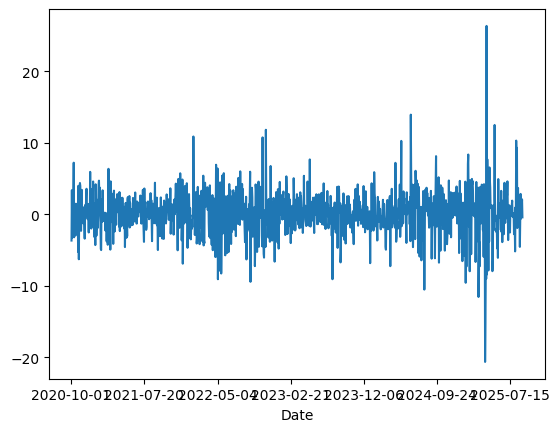

In [218]:
# let's plot to see the difference
df['Close_diff'].plot()

see the autocorellation and corelation

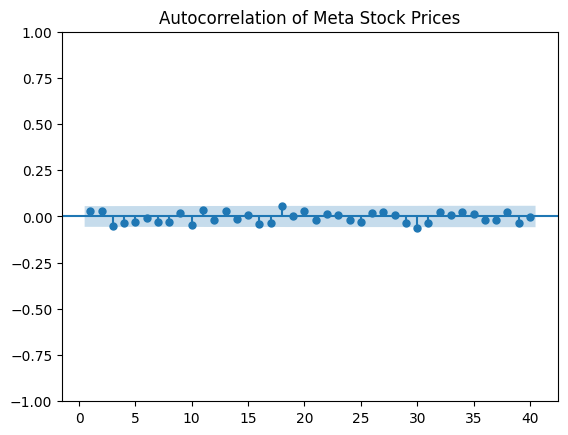

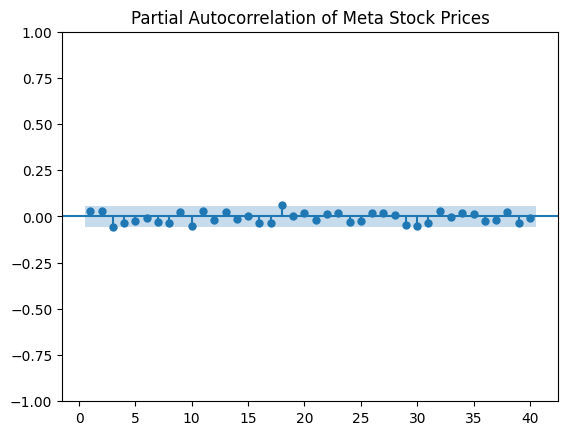

In [219]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
fig = plot_acf(df['Close_diff'].iloc[13:],lags=40
               ,title="Autocorrelation of Meta Stock Prices"
               ,zero=False
               )
fig = plot_pacf(df['Close_diff'].iloc[13:],lags=40
                ,title="Partial Autocorrelation of Meta Stock Prices"
                ,zero=False
                )

train arima model

In [220]:
from statsmodels.tsa.arima.model import ARIMA
model=ARIMA(df['Close'],order=(1,1,1))
model_fit=model.fit()

In [221]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:                 1234
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -3119.754
Date:                Wed, 01 Oct 2025   AIC                           6245.509
Time:                        19:54:48   BIC                           6260.860
Sample:                             0   HQIC                          6251.284
                               - 1234                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2278      0.594      0.383      0.701      -0.937       1.392
ma.L1         -0.1983      0.599     -0.331      0.740      -1.372       0.975
sigma2         9.2308      0.189     48.862      0.000       8.861       9.601
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):              3176.29
Prob(Q):                              0.89   Prob(JB):                         0.00
Heteroskedasticity (H):               2.07   Skew:                             0.19
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.85
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [222]:
print(len(df))

1234


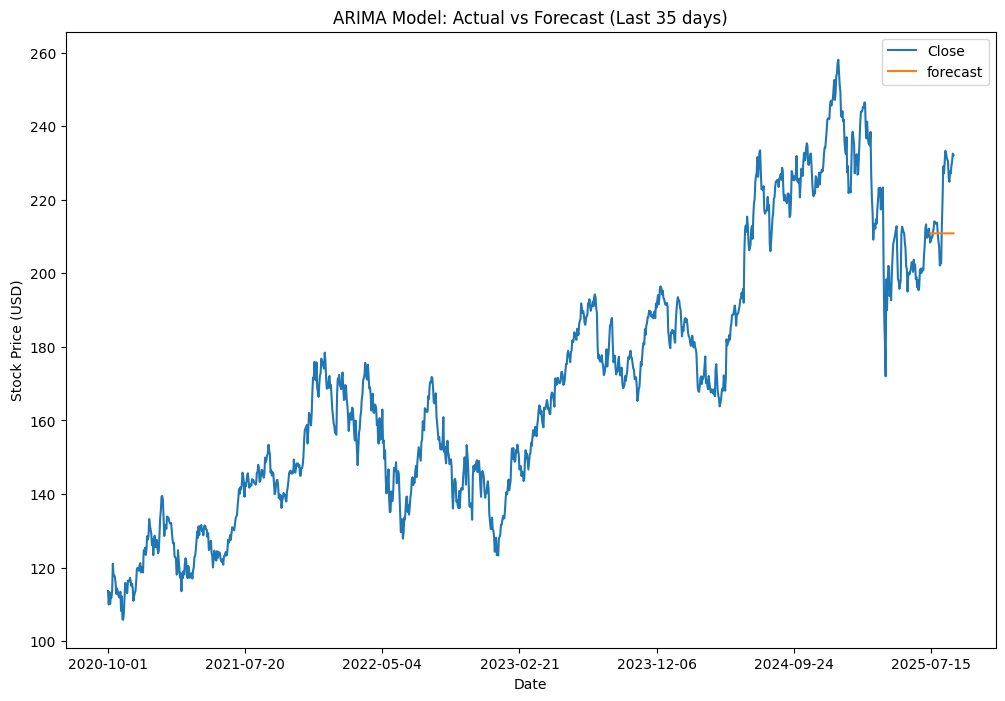

In [223]:
predictions = model_fit.predict(start=len(df)-35, end=len(df)-1, dynamic=True)

df['forecast'] = np.nan

df.iloc[-35:, df.columns.get_loc('forecast')] = predictions.values

df[['Close','forecast']].plot(figsize=(12,8))
plt.title('ARIMA Model: Actual vs Forecast (Last 35 days)')
plt.ylabel('Stock Price (USD)')
plt.show()


It seems not good let's try another way

In [224]:
import statsmodels.api as sm
model=sm.tsa.statespace.SARIMAX(df['Close'],order=(1, 1, 1),seasonal_order=(1,1,1,30))
results=model.fit()

In [225]:
predictions = results.predict(start=len(df)-35, end=len(df)-1, dynamic=True)

df['forecast'] = np.nan

df.iloc[-35:, df.columns.get_loc('forecast')] = predictions.values

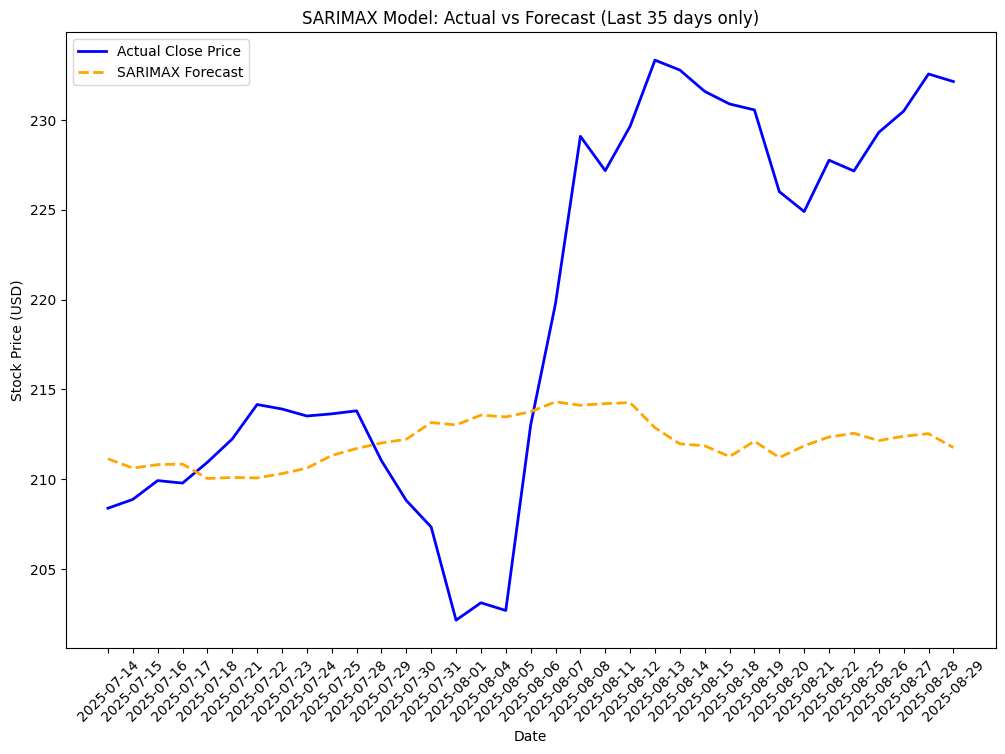

In [226]:
plt.figure(figsize=(12,8))

last_35_days = df[['Close', 'forecast']].iloc[-35:]

plt.plot(last_35_days.index, last_35_days['Close'], 
         label='Actual Close Price', color='blue', linewidth=2)

forecast_data = last_35_days['forecast'].dropna()
plt.plot(forecast_data.index, forecast_data.values, 
         label='SARIMAX Forecast', color='orange', linewidth=2, linestyle='--')

plt.title('SARIMAX Model: Actual vs Forecast (Last 35 days only)')
plt.ylabel('Stock Price (USD)')
plt.xlabel('Date')
plt.legend()
plt.xticks(rotation=45)
plt.show()

from upper obserbation this can be improve by incresing seasonal ordrer

## Implement one machine learning or deep learning model

using prophet

In [227]:
df1 = pd.read_csv("../data/AAPL_stock_data.csv")
df1['Date'] = pd.to_datetime(df1['Date'], utc=True).dt.tz_localize(None)

df1.head()

Date        Open        High         Low       Close  \
0 2020-10-01 04:00:00  114.430515  114.508334  112.669898  113.603706   
1 2020-10-02 04:00:00  109.810111  112.222454  109.158392  109.936562   
2 2020-10-05 04:00:00  110.802282  113.467526  110.452103  113.321617   
3 2020-10-06 04:00:00  112.543451  112.951998  109.187577  110.072754   
4 2020-10-07 04:00:00  111.492912  112.397540  111.016275  111.940361   

      Volume  Dividends  Stock Splits  
0  116120400        0.0           0.0  
1  144712000        0.0           0.0  
2  106243800        0.0           0.0  
3  161498200        0.0           0.0  
4   96849000        0.0           0.0

19:54:59 - cmdstanpy - INFO - Chain [1] start processing
19:54:59 - cmdstanpy - INFO - Chain [1] done processing


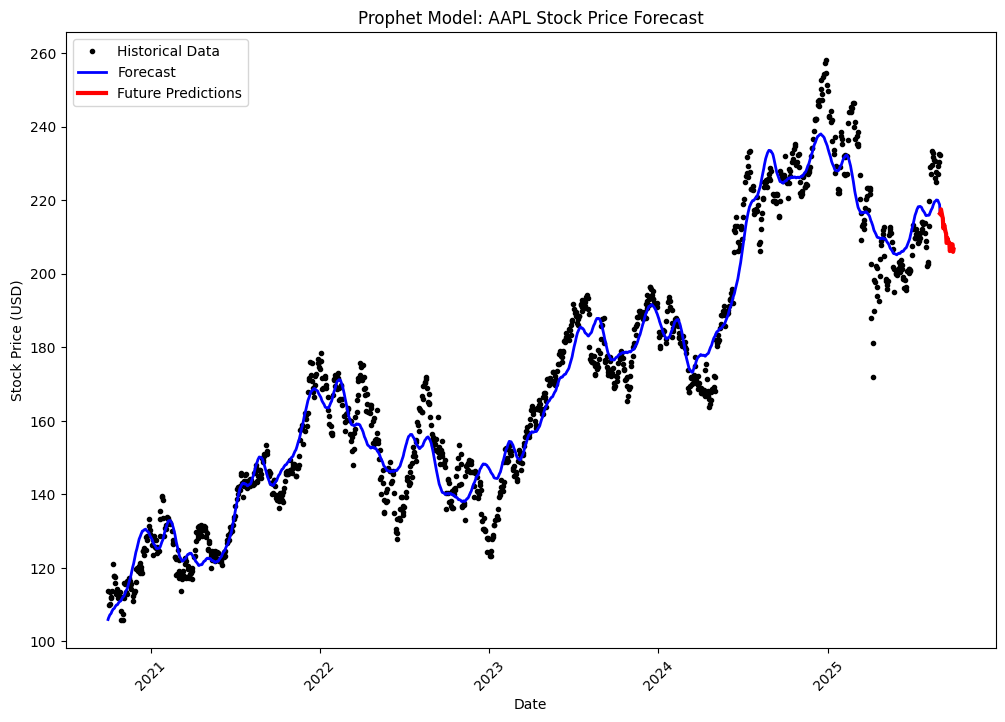

In [228]:
from prophet import Prophet

df_prophet = df1[['Date', 'Close']].copy()

df_prophet = df_prophet.rename(columns={'Date': 'ds', 'Close': 'y'})
model = Prophet()
model.fit(df_prophet)

future = model.make_future_dataframe(periods=30)
forecast = model.predict(future)


import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 8))

ax.plot(df_prophet['ds'], df_prophet['y'], 'ko', markersize=3, label='Historical Data')

ax.plot(forecast['ds'], forecast['yhat'], 'b-', linewidth=2, label='Forecast')

future_start = len(df_prophet)
future_forecast = forecast.iloc[future_start:]
ax.plot(future_forecast['ds'], future_forecast['yhat'], 'r-', linewidth=3, label='Future Predictions')

plt.title('Prophet Model: AAPL Stock Price Forecast')
plt.xlabel('Date')
plt.ylabel('Stock Price (USD)')
plt.legend()
plt.xticks(rotation=45)
plt.show()

deep learning model LSTM


In [ ]:
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf

scaler = MinMaxScaler() # Normalize data
df['Scaled_Close'] = scaler.fit_transform(df[['Close']])


def create_dataset(data, look_back=60): # Create windowed datasets
    x, y = [], []
    for i in range(look_back, len(data)):
        x.append(data[i-look_back:i, 0])
        y.append(data[i, 0])
    return np.array(x), np.array(y)

look_back = 60
data = np.array(df['Scaled_Close']).reshape(-1, 1)
x, y = create_dataset(data, look_back)

split = int(0.8 * len(x)) #split data for train and test
x_train, y_train = x[:split], y[:split]
x_test, y_test = x[split:], y[split:]

x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))

# build and train LSTM model
# model = tf.keras.Sequential([
#     tf.keras.layers.LSTM(50, return_sequences=True, input_shape=(look_back, 1)),
#     tf.keras.layers.LSTM(50),
#     tf.keras.layers.Dense(1)
# ])


model = tf.keras.Sequential([
    tf.keras.layers.LSTM(50, return_sequences=True, input_shape=(look_back, 1)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(50, return_sequences=True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(50),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1),
])


model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, epochs=50, batch_size=32, validation_data=(x_test, y_test))



Epoch 1/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - loss: 0.0216 - val_loss: 0.0149
Epoch 2/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0048 - val_loss: 0.0060
Epoch 3/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0042 - val_loss: 0.0047
Epoch 4/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0038 - val_loss: 0.0071
Epoch 5/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0037 - val_loss: 0.0049
Epoch 6/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0036 - val_loss: 0.0046
Epoch 7/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0037 - val_loss: 0.0044
Epoch 8/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0036 - val_loss: 0.0063
Epoch 9/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0034 - val_loss: 0.0042
Epoch 10/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0033 - val_loss: 0.0058
Epoch 11/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0031 - val_loss: 0.0040
Epoch 12/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0

In [234]:
# Predict and inverse-transform
y_pred = model.predict(x_test)
y_pred_rescaled = scaler.inverse_transform(y_pred.reshape(-1, 1))
y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step


In [238]:
import numpy as np
print(" y pred and y test")
combined = np.column_stack((y_pred_rescaled,y_test_rescaled))
print(combined)



 y pred and y test
[[220.7477417  225.42088318]
 [222.97245789 226.31671143]
 [224.59339905 225.3213501 ]
 [225.24052429 226.46601868]
 [225.26875305 226.73475647]
 [224.99983215 231.92062378]
 [225.52009583 225.16207886]
 [225.48640442 225.72944641]
 [224.97746277 224.62458801]
 [224.08628845 225.74935913]
 [223.34098816 220.66305542]
 [222.09936523 224.72413635]
 [221.34944153 228.47666931]
 [221.85952759 227.97897339]
 [223.16494751 226.49589539]
 [224.41014099 230.22851562]
 [225.85601807 232.76669312]
 [227.63175964 230.70628357]
 [228.94606018 231.0745697 ]
 [229.63414001 233.91137695]
 [230.2399292  235.38452148]
 [231.01647949 234.76739502]
 [231.68110657 229.69100952]
 [231.21321106 229.50189209]
 [229.92951965 230.33799744]
 [228.58096313 232.31878662]
 [227.93267822 232.58753967]
 [228.05114746 229.03407288]
 [228.05726624 224.86347961]
 [227.15112305 221.87738037]
 [225.22892761 220.98153687]
 [222.88536072 222.41487122]
 [221.06430054 221.68824768]
 [219.97775269 226.42620

Accuracy test

In [240]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import numpy as np

rmse = np.sqrt(mean_squared_error(y_test_rescaled, y_pred_rescaled))
mape = mean_absolute_percentage_error(y_test_rescaled, y_pred_rescaled)


print(f"Root Mean Squared Error: {rmse:.2f}")
print(f"Mean Absolute Percentage Error: {mape*100:.2f}%")


Root Mean Squared Error: 6.99
Mean Absolute Percentage Error: 2.35%


plot actual and predicted values

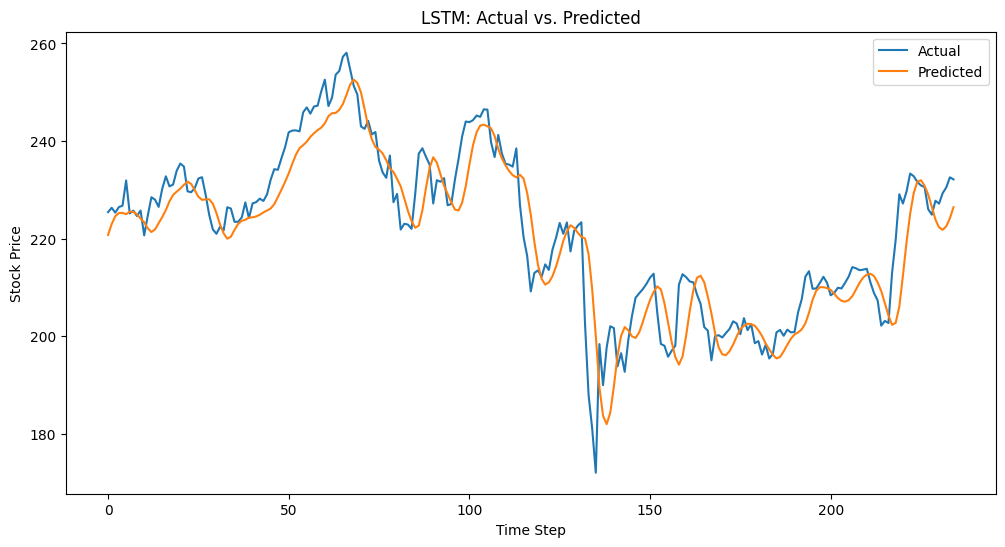

In [241]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(y_test_rescaled, label='Actual')
plt.plot(y_pred_rescaled, label='Predicted')
plt.title('LSTM: Actual vs. Predicted')
plt.xlabel('Time Step')
plt.ylabel('Stock Price')
plt.legend()
plt.show()
